In [52]:
!git pull origin main

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 10.77 KiB | 501.00 KiB/s, done.
From https://github.com/farrukh602/llm-from-scratch
 * branch            main       -> FETCH_HEAD
   c19c0d8..80f8326  main       -> origin/main
Updating c19c0d8..80f8326
Fast-forward
 data/novel.txt | 1196 ++++++++++++++++------------------------------------------------------------
 1 file changed, 246 insertions(+), 950 deletions(-)


In [2]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tiktoken

from utilities.gpt_module import GPTModel
import importlib
from utilities import supporting_modules
from utilities.supporting_modules import create_dataloader, GPTDataset


In [4]:
gpt_config_124m = {
"vocab_size": 50257,
"context_length": 256, #A
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1, #B
"qkv_bias": False
}

##### Text generation Helping functions
A three-step text generation process using a GPT model:
- First, the tokenizer converts input text into a series of token IDs,
- Second, the model receives these token IDs and generates corresponding logits, which are vectors representing the probability distribution for each token in the vocabulary.
- Third, these logits are converted back into token IDs, which the tokenizer decodes into human-readable text, completing the cycle from textual input to textual output.

In [5]:
def generate_text(model, ids, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        ids_cond = ids[:, -context_size:]
        with torch.no_grad():
            logits = model(ids_cond)
        logits_new_token = logits[:, -1, :]
        probas = torch.softmax(logits_new_token, dim=-1)
        ids_next = torch.argmax(probas, dim=-1, keepdim=True) # index of highest probability in probas tensor is actually the id for next token
        ids = torch.cat((ids, ids_next), dim=1) # concatenate new token id with previous ids to generate full text
    return ids


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # to remove batch dimension
    return tokenizer.decode(flat.tolist())

### Setting the data

In [6]:
# file_path = "data/the_verdict.txt"
file_path = "data/novel.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# crafting data loaders
train_loader = create_dataloader(
train_data,
batch_size=2,
max_length=gpt_config_124m["context_length"],
stride=gpt_config_124m["context_length"],
drop_last=True,
shuffle=True
)
val_loader = create_dataloader(
val_data,
batch_size=2,
max_length=gpt_config_124m["context_length"],
stride=gpt_config_124m["context_length"],
drop_last=False,
shuffle=False
)

## Training Function

In [7]:
def cross_entropy_batch_loss(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def loss_calculator(data_loader, model, loss_function, device, num_batches=9):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = loss_function(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

In [8]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(model=model, ids=encoded,
        max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = loss_calculator(train_loader, model, cross_entropy_batch_loss, device, num_batches=eval_iter)
        val_loss = loss_calculator(val_loader, model,  cross_entropy_batch_loss, device,num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [9]:

def train_model(model, train_loader, val_loader, optimizer, device,
               eval_freq, eval_iter, num_epochs, start_context):
    train_losses, val_losses, track_token_seens = [],[], []
    tokens_seen, global_step = 0,-1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_calculator(train_loader, model, cross_entropy_batch_loss, device)
            loss.backward()
            optimizer.step()

            tokens_seen +=input_batch.numel()
            global_step+=1
            if global_step%eval_freq==0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seens.append(tokens_seen)
                print(f"Epoch: {epoch+1} (Step: {global_step: 06d}):",
                     f"Train loss: {train_loss: .3f}, Val loss: {val_loss: .3f}")
            generate_and_print_sample( model, train_loader.dataset.tokenizer, device, start_context)
    return train_losses, val_losses, track_token_seens


In [ ]:
torch.manual_seed(123)
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTModel(gpt_config_124m)

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=0)


num_epochs = 1
train_losses, val_losses, tokens_seen = train_model(model, train_loader, val_loader,
                                                    optimizer, device,
                                                    eval_freq=10, eval_iter=64,
                                                    num_epochs=num_epochs,
                                                    start_context="One of the most remarkable ")

In [29]:
# Save model and optimizer parameters:
torch.save({
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
},
"/content/drive/MyDrive/model_params/llm_gpt2_model_and_optimizer.pth"
)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
train_losses_numpy = np.array([loss.cpu().numpy() for loss in train_losses])
val_losses_numpy = np.array([loss.cpu().numpy() for loss in val_losses])

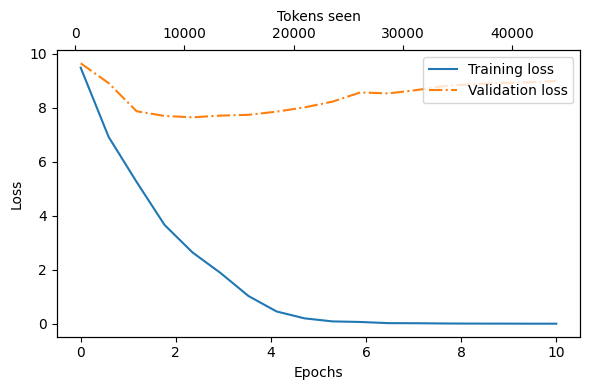

In [31]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(6, 4))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax2 = ax1.twiny() #A
  ax2.plot(tokens_seen, train_losses, alpha=0) #B
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses_numpy, val_losses_numpy)

## Text Generation Strategies to Reduce Training Data Memorizaiton
The model memorizes the training data verbatim by searching for
the generated text snippets because of very small training data. We employ some text generation strategies to generate more diverse output texts.

In [39]:
# Revisiting the generate_text() function
model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
ids = text_to_token_ids("Every one", tokenizer)
context_size=gpt_config_124m["context_length"]
next_text_ids=generate_text(model, ids, max_new_tokens=25, context_size=context_size)
new_text = token_ids_to_text(next_text_ids, tokenizer)
print(new_text)

Every one saw Jack himself on the threshold.

As he stood there, his hands in the pockets of his velveteen coat


Plug the GPTModel instance (model) into the `generate_text`
function, which uses the LLM to generate one token at a time.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
ids = text_to_token_ids("Every effort moves you", tokenizer)
context_size=gpt_config_124m["context_length"]
next_text_ids=generate_text(model, ids, max_new_tokens=50, context_size=context_size)
new_text = token_ids_to_text(next_text_ids, tokenizer)
print(new_text)

NameError: name 'tiktoken' is not defined

## Techniques to control randomness and diversity of generated text